# **DataKit Challenge: Producers Direct**
## **Country, Language, Time Exploration**

By Conrad Kleykamp

Table of Contents:
- [Executive Summary](#1)
- [Set Up](#2)
- [Country Analysis](#3)
- [Date Range Analysis by Country](#4)
- [Visualizations](#5)

## **1) Executive Summary**
---

### **Overview**

Relevant Challenges:

- **Challenge 1: Weather & Agriculture**
- **Challenge 2: Seasonality**

The overarching goal of this project is to identify weather/climate/seasonal patterns (based on temporal data) that may influence the types of questions that farmers ask. Predictive insights may assist farmers by preemptively determining their needs prior to significant weather/climate/seasonal challenges. 

**I am sharing my initial EDA findings, which provide insight into the basic relationships between country, language, and time. This brief analysis may be of use to other members of this project, as it may serve as a reference point for exploring related questions and analytical approaches.** 

### **Current Project Phase: Country Selection**
The first phase of this project is to identify countries with questions predominately in English. This will assist in minimizing translation requirements and ensuring data quality for downstream analysis. Countries were evaluated based on three primary criteria:
- English language prevalence: >70% English language questions to reduce translation complexity
- Question volume: >100,000 questions to enable robust statistical analysis
- Temporal coverage: >3 year data spans to capture seasonal and annual weather variation

### **Initial Findings**
The EDA identified Kenya and Uganda as the primary candidates for my analysis.

**Kenya** emerged as the highest volume country with ~9.76 million questions spanning 4.6 years (2017-2022), with 76.97% English language content. The substantial dataset provides strong statistical power for detecting weather-related patterns, though the ~23% non-English content represents a notable consideration.

**Uganda** was the second highest volume country with ~6.3 million questions spanning 3.8 years (2017-2021), with 70.74% English language content. 

Kenya and Uganda share clear temporal patterns in question volume, with similar upward spikes from the middle to the end of 2018. 

**Tanzania** (4.23 million questions, 0.0% English) and **Great Britain** (316 questions, 100.0% English) were excluded due to language barriers and insufficient volume, respectively.

## **2) Set Up**
---

In [2]:
# Loading in necessary libraries and packages

# Fundamental libraries
import numpy as np 
import pandas as pd 

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'Set2')
pal = sns.color_palette('Set2')

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# Loading in the data (parquet)
print("Loading data...")
df = pd.read_parquet('/kaggle/input/producers-direct-farmer-questionnaire-data/producersdirectdata.parquet')
print(f"Loaded {len(df):,} rows\n")

Loading data...
Loaded 20,304,843 rows



In [5]:
# Parsing dates
print("Parsing dates...")
df['question_sent'] = pd.to_datetime(df['question_sent'], format='ISO8601')
print(f"Dates parsed: {df['question_sent'].notna().sum():,} valid dates")
print(f"Null dates: {df['question_sent'].isna().sum():,}")

Parsing dates...
✓ Dates parsed: 20,304,843 valid dates
  Null dates: 0


## **3) Country Analysis**
---

In [7]:
# Defining country names using the International Naming Convention
COUNTRY_NAMES = {
    'ke': 'Kenya',
    'ug': 'Uganda', 
    'tz': 'Tanzania',
    'gb': 'Great Britain/UK'
}

# Mapping country names to country codes
for code, name in COUNTRY_NAMES.items():
    count = (df['question_user_country_code'] == code).sum()
    print(f"  {code.upper()} = {name:20s} ({count:,} questions)")

  KE = Kenya                (9,758,607 questions)
  UG = Uganda               (6,312,194 questions)
  TZ = Tanzania             (4,233,726 questions)
  GB = Great Britain/UK     (316 questions)


In [15]:
# 1. Country distribution
print("\n1. QUESTION VOLUME BY COUNTRY")
print("-" * 40)
country_counts = df['question_user_country_code'].value_counts()
print(country_counts)

# 2. Language by country
print("\n2. LANGUAGE DISTRIBUTION BY COUNTRY")
print("-" * 40)
lang_by_country = pd.crosstab(
    df['question_user_country_code'], 
    df['question_language'],
    margins=True
)
print(lang_by_country)

# 3. Detailed country statistics with >70% English threshold
print("\n3. COUNTRY STATISTICS (English Threshold: >70%)")
print("-" * 40)

country_lang_summary = df.groupby('question_user_country_code').agg({
    'question_id': 'count',
    'question_language': lambda x: (x == 'eng').sum()
}).rename(columns={
    'question_id': 'total_questions',
    'question_language': 'english_questions'
})

country_lang_summary['english_pct'] = (
    country_lang_summary['english_questions'] / country_lang_summary['total_questions'] * 100
).round(2)

country_lang_summary['non_english_questions'] = (
    country_lang_summary['total_questions'] - country_lang_summary['english_questions']
)

country_lang_summary = country_lang_summary.sort_values('total_questions', ascending=False)

print(country_lang_summary)

# Highlighting countries meeting >70% threshold
print("\nCountries with >70% English questions:")
english_countries = country_lang_summary[country_lang_summary['english_pct'] >= 70]
for idx, row in english_countries.iterrows():
    country_name = COUNTRY_NAMES.get(idx, idx.upper())
    print(f"\n  {idx.upper()} ({country_name}):")
    print(f"    Total questions: {row['total_questions']:,}")
    print(f"    English: {row['english_questions']:,} ({row['english_pct']:.1f}%)")
    print(f"    Non-English: {row['non_english_questions']:,} ({100-row['english_pct']:.1f}%)")


1. QUESTION VOLUME BY COUNTRY
----------------------------------------
question_user_country_code
ke    9758607
ug    6312194
tz    4233726
gb        316
Name: count, dtype: int64

2. LANGUAGE DISTRIBUTION BY COUNTRY
----------------------------------------
question_language                eng     lug      nyn      swa       All
question_user_country_code                                              
gb                               316       0        0        0       316
ke                           7511473       0        0  2247134   9758607
tz                                12       0        0  4233714   4233726
ug                           4464980  689986  1157228        0   6312194
All                         11976781  689986  1157228  6480848  20304843

3. COUNTRY STATISTICS (English Threshold: >70%)
----------------------------------------
                            total_questions  english_questions  english_pct  \
question_user_country_code                                   

## **4) Date Range Analysis by Country**

In [16]:
# Date range analysis
print("\nDATE RANGES FOR COUNTRIES:")
print("-" * 40)

date_stats = {}

for country in country_counts.index:
    
    n_questions_total = country_counts[country]
    
    # Getting dates for this country
    country_mask = df['question_user_country_code'] == country
    country_dates = df.loc[country_mask, 'question_sent']
    
    date_min = country_dates.min()
    date_max = country_dates.max()
    
    # Calculating years span
    days_span = (date_max - date_min).days
    years_span = days_span / 365.25
    
    # Calculating avg questions per year
    avg_questions_per_year = n_questions_total / years_span
    
    country_name = COUNTRY_NAMES.get(country, country.upper())
    
    print(f"\n{country.upper()} ({country_name}):")
    print(f"  Questions: {n_questions_total:,}")
    print(f"  Date range: {date_min.strftime('%Y-%m-%d')} to {date_max.strftime('%Y-%m-%d')}")
    print(f"  Duration: {years_span:.1f} years ({days_span} days)")
    print(f"  Avg questions/year: {avg_questions_per_year:,.0f}")
    
    # Storing statistics for later use
    date_stats[country] = {
        'date_min': date_min,
        'date_max': date_max,
        'years_span': years_span,
        'avg_questions_per_year': avg_questions_per_year,
        'n_questions': n_questions_total
    }


DATE RANGES FOR COUNTRIES:
----------------------------------------

KE (Kenya):
  Questions: 9,758,607
  Date range: 2017-11-22 to 2022-06-21
  Duration: 4.6 years (1672 days)
  Avg questions/year: 2,131,777

UG (Uganda):
  Questions: 6,312,194
  Date range: 2017-11-22 to 2021-09-14
  Duration: 3.8 years (1391 days)
  Avg questions/year: 1,657,461

TZ (Tanzania):
  Questions: 4,233,726
  Date range: 2017-12-13 to 2021-09-16
  Duration: 3.8 years (1372 days)
  Avg questions/year: 1,127,091

GB (Great Britain/UK):
  Questions: 316
  Date range: 2017-12-12 to 2021-07-01
  Duration: 3.5 years (1296 days)
  Avg questions/year: 89


## **5) Visualizations**

✓ Saved visualization to 'country_analysis.png'


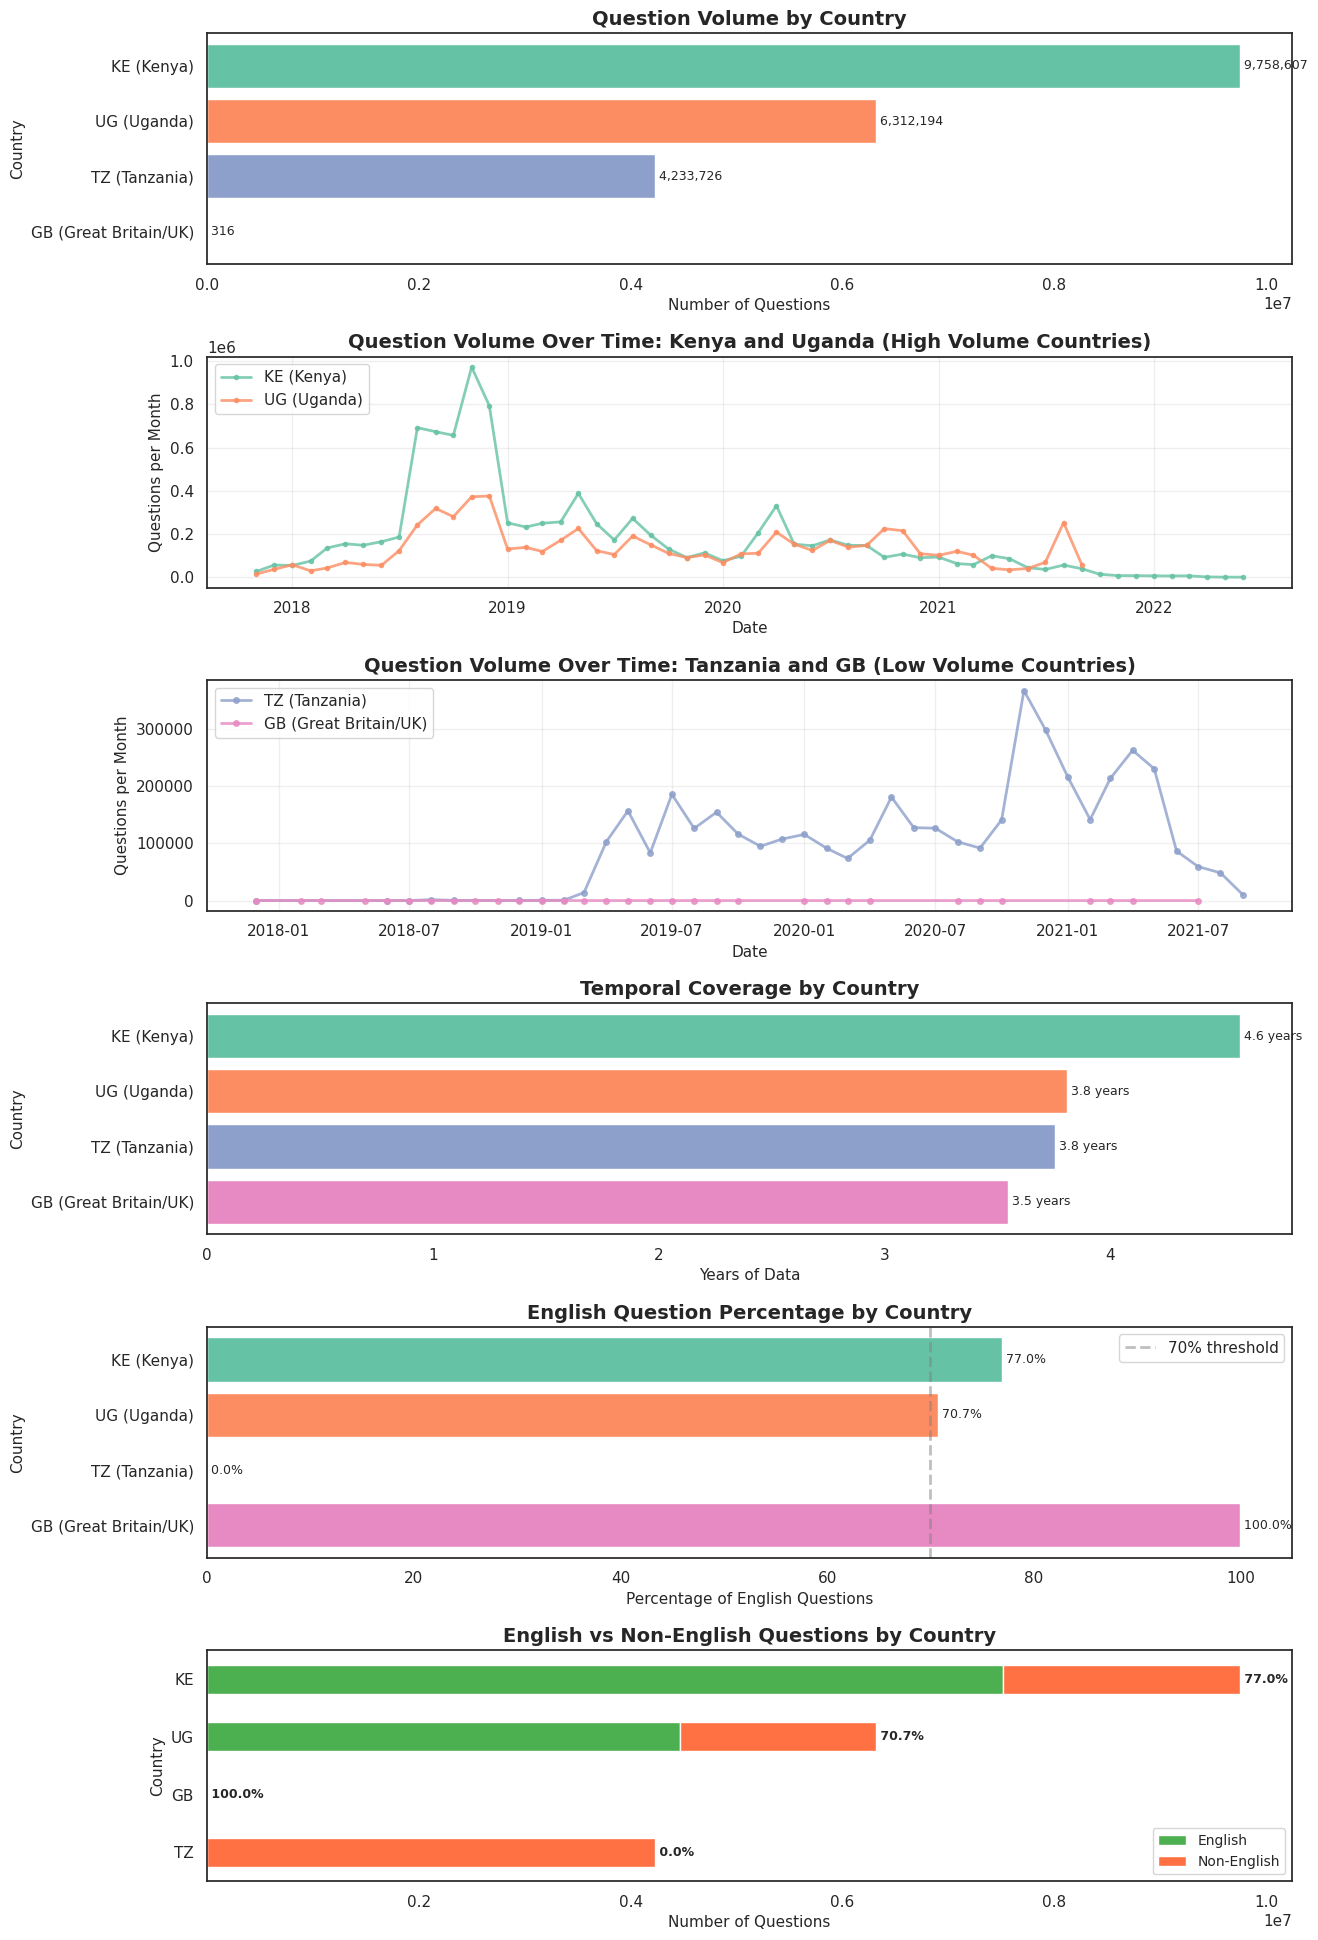

In [17]:
# Creating figure with subplots, stacked vertically
fig = plt.figure(figsize=(14, 24))
gs = fig.add_gridspec(6, 1, hspace=0.4)

# Defining colors for each country using Set2 palette
country_colors = {
    'ke': pal[0],  # First color in Set2
    'ug': pal[1],  # Second color
    'tz': pal[2],  # Third color
    'gb': pal[3]   # Fourth color
}

# Plot 1) Question volume by country
ax1 = fig.add_subplot(gs[0])
colors = [country_colors[c] for c in country_counts.index]
bars = ax1.barh(range(len(country_counts)), country_counts.values, color=colors)
ax1.set_yticks(range(len(country_counts)))
ax1.set_yticklabels([f"{c.upper()} ({COUNTRY_NAMES.get(c, c.upper())})" for c in country_counts.index])
ax1.set_xlabel('Number of Questions', fontsize=11)
ax1.set_ylabel('Country', fontsize=11)
ax1.set_title('Question Volume by Country', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Adding value labels
for i, (country, v) in enumerate(country_counts.items()):
    ax1.text(v, i, f' {v:,}', va='center', fontsize=9)

# Plot 2) Questions over time, KENYA AND UGANDA (high volume)
ax2 = fig.add_subplot(gs[1])

high_volume_countries = ['ke', 'ug']

for country in high_volume_countries:
    country_data = df[df['question_user_country_code'] == country].copy()
    country_data['year_month'] = country_data['question_sent'].dt.to_period('M')
    monthly_counts = country_data.groupby('year_month').size()
    monthly_counts.index = monthly_counts.index.to_timestamp()
    
    country_name = COUNTRY_NAMES.get(country, country.upper())
    ax2.plot(monthly_counts.index, monthly_counts.values, 
            label=f'{country.upper()} ({country_name})', 
            marker='o', markersize=3, linewidth=2, color=country_colors[country], alpha=0.8)

ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Questions per Month', fontsize=11)
ax2.set_title('Question Volume Over Time: Kenya and Uganda (High Volume Countries)', 
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3) Questions over time, TANZANIA AND GB (low volume)
ax3 = fig.add_subplot(gs[2])

low_volume_countries = ['tz', 'gb']

for country in low_volume_countries:
    country_data = df[df['question_user_country_code'] == country].copy()
    country_data['year_month'] = country_data['question_sent'].dt.to_period('M')
    monthly_counts = country_data.groupby('year_month').size()
    monthly_counts.index = monthly_counts.index.to_timestamp()
    
    country_name = COUNTRY_NAMES.get(country, country.upper())
    ax3.plot(monthly_counts.index, monthly_counts.values, 
            label=f'{country.upper()} ({country_name})', 
            marker='o', markersize=4, linewidth=2, color=country_colors[country], alpha=0.8)

ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('Questions per Month', fontsize=11)
ax3.set_title('Question Volume Over Time: Tanzania and GB (Low Volume Countries)', 
             fontsize=14, fontweight='bold')
ax3.legend(fontsize=11, loc='upper left')
ax3.grid(True, alpha=0.3)

# Plot 4) Temporal coverage comparison
ax4 = fig.add_subplot(gs[3])

# Creating data for temporal coverage
countries = list(date_stats.keys())
years_data = [date_stats[c]['years_span'] for c in countries]
colors_years = [country_colors[c] for c in countries]

bars = ax4.barh(range(len(countries)), years_data, color=colors_years)
ax4.set_yticks(range(len(countries)))
ax4.set_yticklabels([f"{c.upper()} ({COUNTRY_NAMES.get(c, c.upper())})" for c in countries])
ax4.set_xlabel('Years of Data', fontsize=11)
ax4.set_ylabel('Country', fontsize=11)
ax4.set_title('Temporal Coverage by Country', fontsize=14, fontweight='bold')
ax4.invert_yaxis()

# Adding value labels
for i, v in enumerate(years_data):
    ax4.text(v, i, f' {v:.1f} years', va='center', fontsize=9)

# Plot 5) English percentage by country
ax5 = fig.add_subplot(gs[4])
colors = [country_colors[idx] for idx in country_lang_summary.index]
bars = ax5.barh(range(len(country_lang_summary)), country_lang_summary['english_pct'].values, color=colors)
ax5.set_yticks(range(len(country_lang_summary)))
ax5.set_yticklabels([f"{idx.upper()} ({COUNTRY_NAMES.get(idx, idx.upper())})" 
                      for idx in country_lang_summary.index])
ax5.set_xlabel('Percentage of English Questions', fontsize=11)
ax5.set_ylabel('Country', fontsize=11)
ax5.set_title('English Question Percentage by Country', fontsize=14, fontweight='bold')
ax5.invert_yaxis()
ax5.axvline(x=70, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='70% threshold')
ax5.legend()

# Adding value labels
for i, v in enumerate(country_lang_summary['english_pct'].values):
    ax5.text(v, i, f' {v:.1f}%', va='center', fontsize=9)

# Plot 6) Stacked bar: English vs Non-English questions
ax6 = fig.add_subplot(gs[5])

english_data = country_lang_summary[['english_questions', 'non_english_questions']].copy()
english_data = english_data.sort_values('english_questions', ascending=True)

english_data.plot(kind='barh', stacked=True, ax=ax6, 
                 color=['#4CAF50', '#FF7043'])

ax6.set_xlabel('Number of Questions', fontsize=11)
ax6.set_ylabel('Country', fontsize=11)
ax6.set_title('English vs Non-English Questions by Country', fontsize=14, fontweight='bold')
ax6.legend(['English', 'Non-English'], fontsize=10, loc='lower right')

# Updating y-tick labels with country names
ax6.set_yticks(range(len(english_data)))
ax6.set_yticklabels([f"{idx.upper()}" for idx in english_data.index])

# Adding percentage labels
for i, (idx, row) in enumerate(english_data.iterrows()):
    total = country_lang_summary.loc[idx, 'total_questions']
    pct = country_lang_summary.loc[idx, 'english_pct']
    ax6.text(total, i, f" {pct:.1f}%", 
            va='center', fontsize=9, fontweight='bold')

# Saving viz
plt.savefig('country_analysis.png', dpi=300, bbox_inches='tight')
print("Saved visualization to 'country_analysis.png'")
# Showing plots
plt.show()